Dataset Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
df = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   horsepower           8996 non-null   float64
 2   vehicle_weight       9704 non-null   float64
 3   model_year           9704 non-null   int64  
 4   fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 379.2 KB


EDA

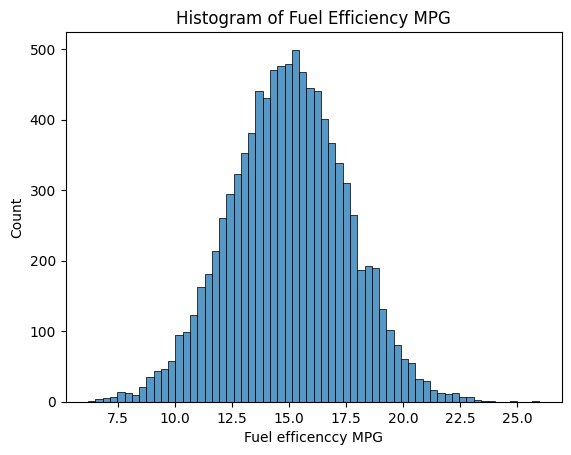

In [4]:
sns.histplot(data=df, x="fuel_efficiency_mpg")
plt.title("Histogram of Fuel Efficiency MPG")
plt.xlabel("Fuel efficenccy MPG")
plt.show()

Q1. Which column has missing values?

In [7]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Q2. What's the median (50% percentile) for variable 'horsepower'?

In [8]:
df['horsepower'].median()

np.float64(149.0)

Prepare and split the dataset

In [9]:
# Shuffle and split
from sklearn.utils import shuffle

df = shuffle(df, random_state=42)
n = len(df)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val

df_train = df.iloc[:n_train].reset_index(drop=True)
df_val = df.iloc[n_train:n_train + n_val].reset_index(drop=True)
df_test = df.iloc[n_train + n_val:].reset_index(drop=True)

In [10]:
# Linear regression (no regularization):
def prepare_X(df):
    X = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']].copy()
    return X.values

def linear_regression(X, y):
    # Add a column of ones for the bias
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    # Closed-form solution
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

def predict(X, w):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    return X @ w

Q3. Which strategy for handling missing values gives a better RMSE?

Option 1: Fill with 0

In [11]:
df_train_0 = df_train.fillna(0)
df_val_0 = df_val.fillna(0)

X_train_0 = prepare_X(df_train_0)
y_train = df_train_0.fuel_efficiency_mpg.values

w0 = linear_regression(X_train_0, y_train)

X_val_0 = prepare_X(df_val_0)
y_val = df_val_0.fuel_efficiency_mpg.values

y_pred_0 = predict(X_val_0, w0)
rmse_0 = np.sqrt(np.mean((y_val - y_pred_0) ** 2))
print("RMSE (fill with 0):", round(rmse_0, 2))

RMSE (fill with 0): 0.52


Option 2: Fill with the mean

In [12]:
means = df_train.mean()
df_train_mean = df_train.fillna(means)
df_val_mean = df_val.fillna(means)

X_train_mean = prepare_X(df_train_mean)
y_train = df_train_mean.fuel_efficiency_mpg.values

w_mean = linear_regression(X_train_mean, y_train)

X_val_mean = prepare_X(df_val_mean)
y_val = df_val_mean.fuel_efficiency_mpg.values

y_pred_mean = predict(X_val_mean, w_mean)
rmse_mean = np.sqrt(np.mean((y_val - y_pred_mean) ** 2))
print("RMSE (fill with mean):", round(rmse_mean, 2))

RMSE (fill with mean): 0.46



Q4. Which r gives the best RMSE?

In [13]:
def prepare_X(df):
    features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# Prepare data
X_train = prepare_X(df_train)
y_train = df_train['fuel_efficiency_mpg'].values

X_val = prepare_X(df_val)
y_val = df_val['fuel_efficiency_mpg'].values

# Try different r
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = []

for r in r_values:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    score_rounded = round(score, 2)
    print(f"r={r:>6}: RMSE={score_rounded}")

r=     0: RMSE=0.52
r=  0.01: RMSE=0.52
r=   0.1: RMSE=0.52
r=     1: RMSE=0.52
r=     5: RMSE=0.52
r=    10: RMSE=0.52
r=   100: RMSE=0.52


Q5. What's the value of std?

In [14]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

rmse_scores = []

for seed in range(10):
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    n = len(df_shuffled)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    n_test = n - n_train - n_val

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    # (test set not used)

    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)

    # Prepare X and y
    X_train = df_train[features].values
    y_train = df_train['fuel_efficiency_mpg'].values

    X_val = df_val[features].values
    y_val = df_val['fuel_efficiency_mpg'].values

    # Train
    w0, w = train_linear_regression(X_train, y_train)

    # Predict
    y_pred = w0 + X_val.dot(w)

    # Score
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)

    print(f"Seed: {seed} -> RMSE: {round(score, 3)}")

std = np.std(rmse_scores)
print("Standard deviation:", round(std, 3))

Seed: 0 -> RMSE: 0.516
Seed: 1 -> RMSE: 0.509
Seed: 2 -> RMSE: 0.516
Seed: 3 -> RMSE: 0.527
Seed: 4 -> RMSE: 0.533
Seed: 5 -> RMSE: 0.518
Seed: 6 -> RMSE: 0.513
Seed: 7 -> RMSE: 0.53
Seed: 8 -> RMSE: 0.507
Seed: 9 -> RMSE: 0.521
Standard deviation: 0.008


Question 6. Evaluation on test 

In [15]:
seed = 9
df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
n = len(df_shuffled)
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - n_train - n_val

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

df_full_train = df_full_train.fillna(0)
df_test = df_test.fillna(0)

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_full_train = df_full_train[features].values
y_full_train = df_full_train['fuel_efficiency_mpg'].values

X_test = df_test[features].values
y_test = df_test['fuel_efficiency_mpg'].values

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

# Train
r = 0.001
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=r)

y_pred = w0 + X_test.dot(w)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE on test set:", round(rmse, 2))

RMSE on test set: 0.53
